In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [29]:
from diffusers import DiffusionPipeline
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp
from rembg import remove

from PIL import Image
import numpy as np

In [32]:
def crop_fit(image):
    data = np.array(image)
    alpha_channel = data[:, :, 3]
    non_empty_pixels = np.where(alpha_channel > 0)

    y_min, y_max = np.min(non_empty_pixels[0]), np.max(non_empty_pixels[0])
    x_min, x_max = np.min(non_empty_pixels[1]), np.max(non_empty_pixels[1])

    return image.crop((x_min, y_min, x_max + 1, y_max + 1))

In [33]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-0.9", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

pipe.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
pipe.vae.enable_xformers_memory_efficient_attention(attention_op=None)
pipe = pipe.to(0)

In [34]:
refiner = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-0.9", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

refiner.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
refiner.vae.enable_xformers_memory_efficient_attention(attention_op=None)
refiner = refiner.to(0)

In [ ]:
for animal in animals:
    save_path = os.path.join("pseudo_new", animal)
    os.makedirs(save_path, exist_ok=True)
    
    for i in range(200):
        prompt = f"a {animal} facing forwards. I want to see the whole body of the {animal}."
        
        image = pipe(prompt, output_type="latent").images[0]
        image = refiner(prompt=prompt, image=image).images[0]
        image = remove(image)
        image = crop_fit(image)
        
        image.save(os.path.join(save_path, f"{i}.png")) 
        print(os.path.join(save_path, f"{i}.png"))    

  0%|          | 0/50 [00:00<?, ?it/s]

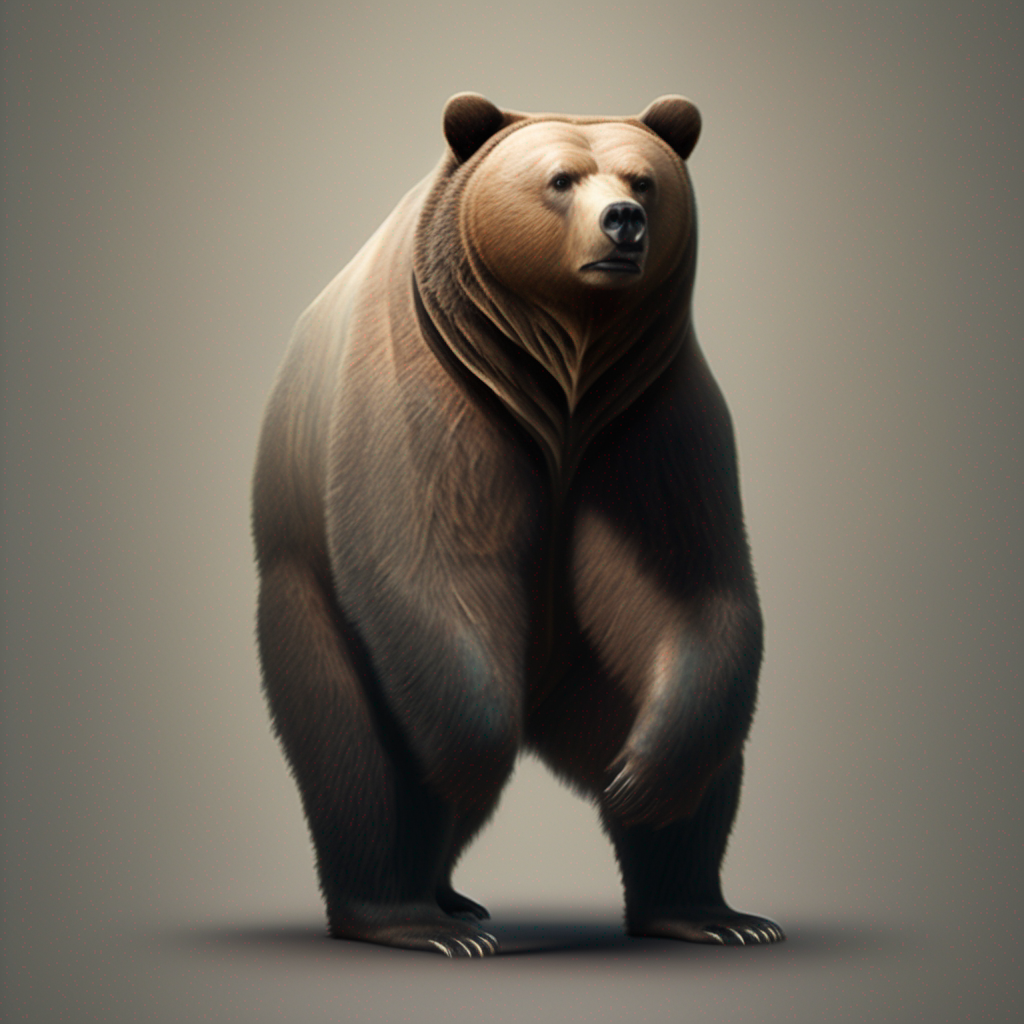

In [44]:
animal = 'bear'
prompt =         prompt = f"a {animal} facing forwards. I want to see the whole body of the {animal}."

image = pipe(prompt).images[0]
# image = refiner(prompt=prompt, image=image).images[0]
# image = remove(image)    
# image = crop_fit(image)

image